# Comparing estimators for π0

## Setting the scene

In [1]:
using MultipleTesting

In [ ]:
using Distributions
using DataFrames
using Gadfly
using Compose

## Simulation

We will simulate p-values under the null and alternative hypothesis by drawing from random variable distributions. For the null hypothesis, p-values are uniformly distributed in the interval [0,1]; p-values under the alternative hypothesis are modelled by a Beta distribution with a momotonically decreasing density.

In [3]:
distr_h0 = Uniform()
distr_h1 = Beta(0.5, 3)

Distributions.Beta(α=0.5, β=3.0)

In [4]:
simulate_mixed_pvalues(d1, n1, d2, n2) = [rand(d1, n1); rand(d2, n2)]

simulate_mixed_pvalues (generic function with 1 method)

In [5]:
x = linspace(0.001, 1.0, 200)
pdf_h0 = pdf(distr_h0, x);
pdf_h1 = pdf(distr_h1, x);

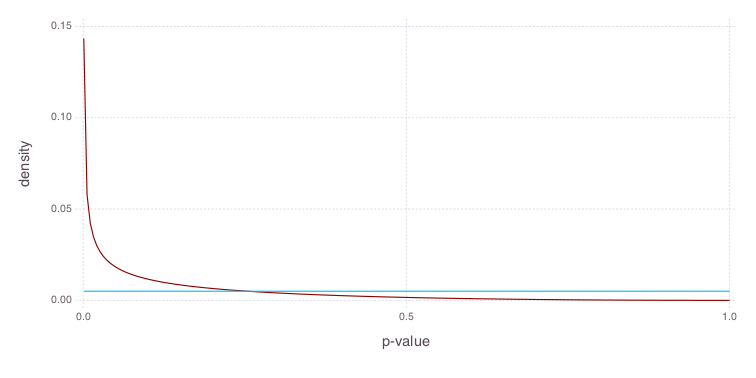

In [6]:
p = plot(
    layer(x = x, y = pdf_h0/sum(pdf_h0), Geom.line),
    layer(x = x, y = pdf_h1/sum(pdf_h1), Geom.line, Theme(default_color = colorant"darkred")),
    Guide.xlabel("p-value"), Guide.ylabel("density")
)
draw(PNG(20cm, 10cm), p)

## Assessment of π0 estimators

We assess the performance of three estimators for π0, the fraction of tests under the null hypothesis. Here, we compare different estimators. Using the mixture model from above, we simulate p-values with a true π0 of 0.8, i.e. 20% of the p-values come from the alternative model.

In [7]:
estimators = ["Storey",
              "StoreyBootstrap",
              "LeastSlope",
              "TwoStep",
              "RightBoundary",
              "CensoredBUM",
              "BUM",
              "FlatGrenander"];

In [8]:
n0 = 400
n1 = 100
pi0 = n0/(n0+n1)
m = 500

500

In [ ]:
pi0hat = zeros(m, length(estimators))
for i in 1:m
    pvals = simulate_mixed_pvalues(distr_h0, n0, distr_h1, n1)
    for (j, e) in enumerate(estimators)
        pi0estimator = call(eval(parse(e)))
        pi0hat[i,j] = estimate_pi0(pvals, pi0estimator)
    end
end

In [10]:
pi0hat[isnan(pi0hat)] = 1.0;

In [11]:
df = convert(DataFrame, pi0hat)
names!(df, map(symbol, estimators))
df = stack(df, collect(1:length(estimators)))
names!(df, [:estimator, :pi0hat]);

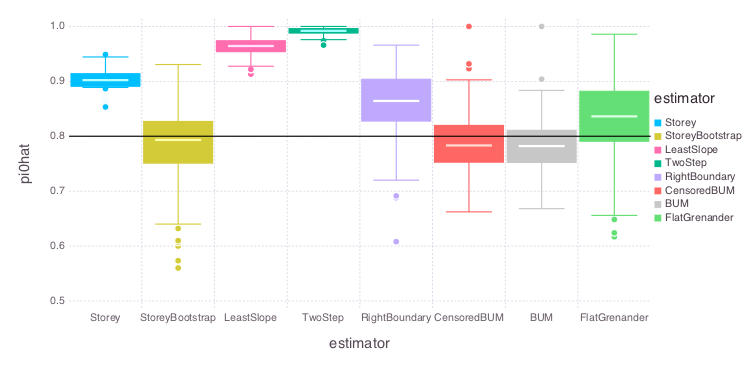

In [12]:
p = plot(
    layer(yintercept = [pi0], Geom.hline(color = colorant"black")),
    layer(df, x = "estimator", y = "pi0hat", color = "estimator", Geom.boxplot)
)
draw(PNG(20cm, 10cm), p)

Visualizing the estimated π0 for the three estimators shows us a typical bias-variance tradeoff: The bootstrap has a small bias with regard to the true value (black horizontal line), but exhibits a large degree of variablity. In contrast, the two step estimator has the lowest spread, while clearly overestimating π0.